In [1]:
#so empty
from ase.io import read
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

def gaussian(x, mu, sig):
    return 1/sig/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/(2*sig**2))

indices of pos_list[:,:,:] go over time, atoms, cart

Equation to implement is 

$G_{d}(r,t) = N^{-1} \sum_{i} \sum_{j \neq i} \langle \delta(r - |r_i(t) - r_j
(0)|) \rangle $



Implementation:

for each atom_${i}$ at t=t place it in atoms at t=0, remove the same atoms by index, then calculate all distance to neighbor atoms j within a cutoff using matscipy's neighbors_list. Perform convolution then average over atom i.

In [92]:
from matscipy.neighbours import neighbour_list
from tqdm import tqdm
from matscipy.neighbours import mic 

# def convolution(d)

def d_to_acf(r_t_it0_j0, r_cut = 5.0,grid_size=201):
    r_grid = np.linspace(0,r_cut, grid_size)
    acf_t = np.zeros([r_t_it0_j0.shape[0],grid_size])
    for t, r_it0_j0 in enumerate(r_t_it0_j0):
        mask1 = r_it0_j0<r_cut
        mask2 = r_it0_j0>0.
        for mu in r_it0_j0[np.logical_and(mask1, mask2)].ravel():
            acf_t[t] += 1/mu**2 * gaussian(r_grid, mu, sig=0.1)
    acf_t /= (r_t_it0_j0.shape[1])*(r_t_it0_j0.shape[1]-1)
    return r_grid, acf_t
        
def d_to_acf2(r_t0_t_it0_j0, r_cut = 5.0,grid_size=201):
    r_grid = np.linspace(0,r_cut, grid_size)
    acf_t = np.zeros([r_t0_t_it0_j0.shape[0],grid_size])
    for t, r_it0_j0 in enumerate(r_t0_t_it0_j0):
        mask1 = r_it0_j0<r_cut
        mask2 = r_it0_j0>0.
        hist, bin_edges = np.histogram(r_it0_j0[np.logical_and(mask1,mask2)], r_grid)
        bin_center = (bin_edges[:-1] + bin_edges[1:])/2
        for mu, count in zip(bin_center,hist):
             acf_t[t] += 1/mu**2 *count * gaussian(r_grid, mu, sig=0.1)
    #     mask1 = r_it0_j0<r_cut
    #     mask2 = r_it0_j0>0.
    #     for mu in r_it0_j0[np.logical_and(mask1, mask2)].ravel():
    #         acf_t[t] += 1/mu**2 * gaussian(r_grid, mu, sig=0.1)
    # print(acf_t.shape)
    # print(r_t0_t_it0_j0.shape)
    acf_t /= (r_t0_t_it0_j0.shape[1])*(r_t0_t_it0_j0.shape[1]-1)
    acf_t = acf_t.sum(axis=0)
    return r_grid, acf_t
        

def hv_acf_d_avg(traj):
    n_atoms = len(traj[0])
    n_time = len(traj)
    acf_t = []
    r_t_it0_j0 = np.zeros([n_time, n_atoms,n_atoms])
    for t_idx, atoms_t in enumerate(tqdm(traj)):
        #r_it0_j0 = np.zeros([n_atoms,n_atoms])
        for i in range(n_atoms):
            atoms_t0 = traj[0]
            dis_vec = np.vstack([
                atoms_t0.get_positions()[:i], 
                atoms_t.get_positions()[i], 
                atoms_t0.get_positions()[i+1:]]
                ) - atoms_t.get_positions()[i]
            r_t_it0_j0[t_idx, i] = np.linalg.norm(mic(dis_vec, atoms_t.cell),axis=1)
        #r_t_it0_j0.append(r_it0_j0)
        #acf.append(np.average(rdf_i, axis=0))
        #acf_t.append(d_to_acf2(r_t_it0_j0)[1]/r_t_it0_j0.shape[0])
    r, acf_t = d_to_acf(r_t_it0_j0)
    return r, acf_t

def hv_acf_d_time_average(traj):
    n_atoms = len(traj[0])
    n_time = len(traj)
    acf_t = []
    for t_lag_idx in tqdm(range(n_time)):
        r_t_it0_j0 = np.zeros([n_time-t_lag_idx, n_atoms,n_atoms])
        #for t_idx, atoms_t in enumerate(tqdm(traj)):
        #print(len(traj[t0_idx:]))
        for t_idx in range(n_time-t_lag_idx):
            #r_it0_j0 = np.zeros([n_atoms,n_atoms])
            atoms_t = traj[t_idx]
            atoms_t0 = traj[t_idx + t_lag_idx]
            #print(t_idx, t_idx + t_lag_idx)
            for i in range(n_atoms):
                dis_vec = np.vstack([
                    atoms_t0.get_positions()[:i], 
                    atoms_t.get_positions()[i], 
                    atoms_t0.get_positions()[i+1:]]
                    ) - atoms_t.get_positions()[i]
                r_t_it0_j0[t_idx, i] = np.linalg.norm(mic(dis_vec, atoms_t.cell),axis=1)
            r_grid, acf_t_idx = d_to_acf2(r_t_it0_j0, r_cut = 4.0,grid_size=201)
        acf_t.append(acf_t_idx/r_t_it0_j0.shape[0])
        #acf_t.append(d_to_acf2(r_t_it0_j0)[1])
        #acf.append(np.average(rdf_i, axis=0))
    return r_grid, acf_t

from ase.io import read
traj = read('./traj/md_seed_0_conc0.2500_800K.traj', ':')

In [10]:
from matscipy.neighbours import neighbour_list
from tqdm import tqdm
from matscipy.neighbours import mic 

# def convolution(d)

def d_to_acf(r_t_it0_j0, r_cut = 5.0,grid_size=201):
    r_grid = np.linspace(0,r_cut, grid_size)
    acf_t = np.zeros([r_t_it0_j0.shape[0],grid_size])
    for t, r_it0_j0 in enumerate(r_t_it0_j0):
        mask1 = r_it0_j0<r_cut
        mask2 = r_it0_j0>0.
        for mu in r_it0_j0[np.logical_and(mask1, mask2)].ravel():
            acf_t[t] += 1/mu**2 * gaussian(r_grid, mu, sig=0.1)
    acf_t /= (r_t_it0_j0.shape[1])*(r_t_it0_j0.shape[1]-1)
    return r_grid, acf_t
        
def d_to_acf2(r_t0_t_it0_j0, r_cut = 5.0,grid_size=201):
    r_grid = np.linspace(0,r_cut, grid_size)
    acf_t = np.zeros([r_t0_t_it0_j0.shape[0],grid_size])
    for t, r_it0_j0 in enumerate(r_t0_t_it0_j0):
        mask1 = r_it0_j0<r_cut
        mask2 = r_it0_j0>0.
        hist, bin_edges = np.histogram(r_it0_j0[np.logical_and(mask1,mask2)], r_grid)
        bin_center = (bin_edges[:-1] + bin_edges[1:])/2
        for mu, count in zip(bin_center,hist):
             acf_t[t] += 1/mu**2 *count * gaussian(r_grid, mu, sig=0.1)
    #     mask1 = r_it0_j0<r_cut
    #     mask2 = r_it0_j0>0.
    #     for mu in r_it0_j0[np.logical_and(mask1, mask2)].ravel():
    #         acf_t[t] += 1/mu**2 * gaussian(r_grid, mu, sig=0.1)
    # print(acf_t.shape)
    # print(r_t0_t_it0_j0.shape)
    acf_t /= (r_t0_t_it0_j0.shape[1])*(r_t0_t_it0_j0.shape[1]-1)
    acf_t = acf_t.sum(axis=0)
    return r_grid, acf_t
        

def hv_acf_d_avg(traj):
    n_atoms = len(traj[0])
    n_time = len(traj)
    acf_t = []
    r_t_it0_j0 = np.zeros([n_time, n_atoms,n_atoms])
    for t_idx, atoms_t in enumerate(tqdm(traj)):
        #r_it0_j0 = np.zeros([n_atoms,n_atoms])
        for i in range(n_atoms):
            atoms_t0 = traj[0]
            dis_vec = np.vstack([
                atoms_t0.get_positions()[:i], 
                atoms_t.get_positions()[i], 
                atoms_t0.get_positions()[i+1:]]
                ) - atoms_t.get_positions()[i]
            r_t_it0_j0[t_idx, i] = np.linalg.norm(mic(dis_vec, atoms_t.cell),axis=1)
        #r_t_it0_j0.append(r_it0_j0)
        #acf.append(np.average(rdf_i, axis=0))
        #acf_t.append(d_to_acf2(r_t_it0_j0)[1]/r_t_it0_j0.shape[0])
    r, acf_t = d_to_acf(r_t_it0_j0)
    return r, acf_t

def hv_acf_d_time_average(traj):
    n_atoms = len(traj[0])
    n_time = len(traj)
    acf_t = []
    for t_lag_idx in tqdm(range(n_time)):
        r_t_it0_j0 = np.zeros([n_time-t_lag_idx, n_atoms,n_atoms])
        #for t_idx, atoms_t in enumerate(tqdm(traj)):
        #print(len(traj[t0_idx:]))
        for t_idx in range(n_time-t_lag_idx):
            #r_it0_j0 = np.zeros([n_atoms,n_atoms])
            atoms_t = traj[t_idx]
            atoms_t0 = traj[t_idx + t_lag_idx]
            #print(t_idx, t_idx + t_lag_idx)
            for i in range(n_atoms):
                dis_vec = np.vstack([
                    atoms_t0.get_positions()[:i], 
                    atoms_t.get_positions()[i], 
                    atoms_t0.get_positions()[i+1:]]
                    ) - atoms_t.get_positions()[i]
                r_t_it0_j0[t_idx, i] = np.linalg.norm(mic(dis_vec, atoms_t.cell),axis=1)
        r_grid, acf_t_idx = d_to_acf2(r_t_it0_j0, r_cut = 4.0,grid_size=201)
        acf_t.append(acf_t_idx/r_t_it0_j0.shape[0])
        #acf_t.append(d_to_acf2(r_t_it0_j0)[1])
        #acf.append(np.average(rdf_i, axis=0))
    return r_grid, acf_t

from ase.io import read
traj = read('./traj/md_seed_0_conc0.2500_800K.traj', ':')

In [3]:
# from ase.io import read
# traj = read('./traj/md_seed_0_conc0.5000_800K.traj', ':')

r, acf_t = hv_acf_d_avg(
    [atoms[[atom.index for atom in atoms if atom.symbol=='H']] for atoms in traj]
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 89.77it/s]


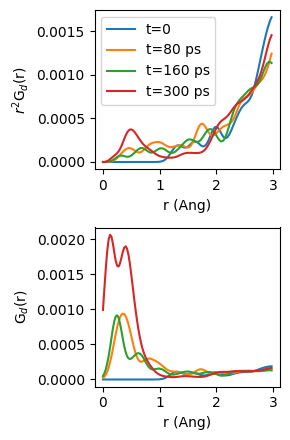

In [77]:
# r, acf_t = d_to_acf(r_t_it0_j0)
import matplotlib.pyplot as plt

# r = np.linspace(0, 3, 1000)

fig, ax = plt.subplots(2,1,figsize=[3,4.5])

x = r[r<3]
y = [y[r<3] for y in acf_t]

ax[0].plot(x, y[0]*x**2)
ax[0].plot(x, y[40]*x**2)
ax[0].plot(x, y[80]*x**2)
ax[0].plot(x, y[149]*x**2)
#ax[0].set_xlim([0,6])
#ax[0].set_ylim([0,0.5])
ax[0].set_ylabel(r'$r^{2}$G$_{d}$(r)')
ax[0].set_xlabel('r (Ang)')
ax[1].plot(x, y[0])
ax[1].plot(x, y[40])
ax[1].plot(x, y[80])
ax[1].plot(x, y[149])

# # inset Axes....
# x1, x2, y1, y2 = 2, 3, 0, 0.1  # subregion of the original image
# axins = ax[1].inset_axes(
#     [0.5, 0.5, 0.47, 0.47],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# #axins.plot(r,, extent=extent, origin="lower")
# axins.plot(r, acf[0])
# axins.plot(r, acf[40])
# axins.plot(r, acf[80])
# axins.plot(r, acf[149])

# ax[1].indicate_inset_zoom(axins, edgecolor="black")

#ax[1].set_xlim([0,6])
ax[1].set_ylabel(r'G$_{d}$(r)')
ax[1].set_xlabel('r (Ang)')
ax[0].legend(['t=0', 't=80 ps', 't=160 ps', 't=300 ps'])
fig.tight_layout()
fig.savefig('acf.png', dpi=300)

In [88]:
r, acf_t = hv_acf_d_time_average(
    [atoms[[atom.index for atom in atoms if atom.symbol=='H']] for atoms in traj[:100]]
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


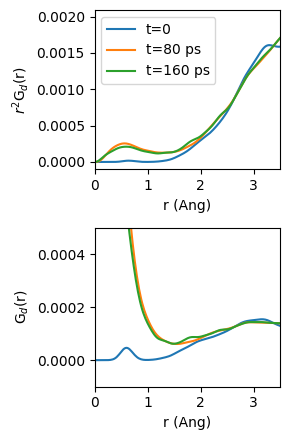

In [94]:
import matplotlib.pyplot as plt

# r = np.linspace(0, 3, 1000)

fig, ax = plt.subplots(2,1,figsize=[3,4.5])

x = r
y = acf_t

ax[0].plot(x, y[0]*x**2)
ax[0].plot(x, y[40]*x**2)
ax[0].plot(x, y[80]*x**2)
#ax[0].plot(x, y[149]*x**2)
#ax[0].set_xlim([0,6])
#ax[0].set_ylim([0,0.5])
ax[0].set_ylabel(r'$r^{2}$G$_{d}$(r)')
ax[0].set_xlabel('r (Ang)')
ax[1].plot(x, y[0])
ax[1].plot(x, y[40])
ax[1].plot(x, y[80])
#ax[1].plot(x, y[149])

# # inset Axes....
# x1, x2, y1, y2 = 2, 3, 0, 0.1  # subregion of the original image
# axins = ax[1].inset_axes(
#     [0.5, 0.5, 0.47, 0.47],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# #axins.plot(r,, extent=extent, origin="lower")
# axins.plot(r, acf[0])
# axins.plot(r, acf[40])
# axins.plot(r, acf[80])
# axins.plot(r, acf[149])

# ax[1].indicate_inset_zoom(axins, edgecolor="black")

ax[1].set_ylim([-0.0001,0.0005])
ax[0].set_xlim([-0.0001,3.5])
ax[1].set_xlim([-0.0001,3.5])
ax[1].set_ylabel(r'G$_{d}$(r)')
ax[1].set_xlabel('r (Ang)')
ax[0].legend(['t=0', 't=80 ps', 't=160 ps', 't=300 ps'])
fig.tight_layout()
fig.savefig('acf_t0.png', dpi=300)

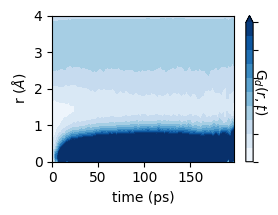

In [90]:
time_step = 2 #ps
time = 2* np.arange(len(traj[:100]))
x, y = np.meshgrid(time,r)
Z = np.array(acf_t).T

fig, ax = plt.subplots(figsize=[3, 2.25])

norm = cm.colors.Normalize(vmax=0.0004, vmin=0)
levels = np.linspace(0.0, 0.0004, 11)
pos = ax.contourf(
    x,
    y,
    Z,
    levels = levels,
    norm=norm,
    #extent=(x.min(), x.max(), y.min(), y.max()), 
    cmap='Blues', 
    extend = 'max',
    #vmin=0, 
    #vmax=0.001, 
    #interpolation='nearest'
)

ax.set_ylabel(r'r ($\AA{}$)')
ax.set_xlabel('time (ps)')

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_yticklabels([])
cbar.ax.set_ylabel(r'G$_{d}(r,t)$', rotation=270)
fig.tight_layout()

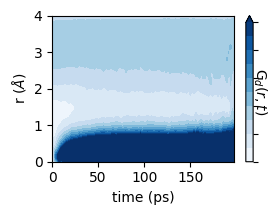

In [82]:
time_step = 2 #ps
time = 2* np.arange(len(traj[50:]))
x, y = np.meshgrid(time,r)
Z = np.array(acf_t).T

fig, ax = plt.subplots(figsize=[3, 2.25])

norm = cm.colors.Normalize(vmax=0.0004, vmin=0)
levels = np.linspace(0.0, 0.0004, 11)
pos = ax.contourf(
    x,
    y,
    Z,
    levels = levels,
    norm=norm,
    #extent=(x.min(), x.max(), y.min(), y.max()), 
    cmap='Blues', 
    extend = 'max',
    #vmin=0, 
    #vmax=0.001, 
    #interpolation='nearest'
)

ax.set_ylabel(r'r ($\AA{}$)')
ax.set_xlabel('time (ps)')

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_yticklabels([])
cbar.ax.set_ylabel(r'G$_{d}(r,t)$', rotation=270)
fig.tight_layout()

In [7]:
traj_H = [atoms[[atom.index for atom in atoms if atom.symbol=='H']] for atoms in traj]
n_atoms = len(traj_H[0])
n_time = len(traj_H)
for t_lag_idx in tqdm(range(0,1)):
    r_t_it0_j0 = np.zeros([n_time-t_lag_idx, n_atoms,n_atoms])
    #for t_idx, atoms_t in enumerate(tqdm(traj)):
    #print(len(traj[t0_idx:]))
    for t_idx in range(n_time-t_lag_idx):
        #r_it0_j0 = np.zeros([n_atoms,n_atoms])
        atoms_t = traj_H[t_idx]
        atoms_t0 = traj_H[t_idx + t_lag_idx]
        #print(t_idx, t_idx + t_lag_idx)
        for i in range(n_atoms):
            dis_vec = np.vstack([
                atoms_t0.get_positions()[:i], 
                atoms_t.get_positions()[i], 
                atoms_t0.get_positions()[i+1:]]
                ) - atoms_t.get_positions()[i]
            r_t_it0_j0[t_idx, i] = np.linalg.norm(mic(dis_vec, atoms_t.cell),axis=1)

r_grid = np.linspace(0,5,201)
acf_t = np.zeros([r_t_it0_j0.shape[0],201])
for t, r_it0_j0 in enumerate(r_t_it0_j0):
    mask1 = r_it0_j0<5
    mask2 = r_it0_j0>0.
    for mu in r_it0_j0[np.logical_and(mask1, mask2)].ravel():
        acf_t[t] += 1/mu**2 * gaussian(r_grid, mu, sig=0.1)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


In [9]:
i, j, d = neighbor_list("ijD",a=traj_H[0], cutoff=1.0)

In [15]:
from ase.neighborlist import neighbor_list
np.set_printoptions(legacy='1.25')
for traj_idx, atoms in enumerate(traj_H):
    i, j, d = neighbor_list("ijD",a=atoms, cutoff=0.9)
    if len(i) > 0:
        print(f"atoms {traj_idx} H_{i} to H_{j}")
        print(f"distance is {[np.linalg.norm(vec) for vec in d]}")

atoms 5 H_[16 36] to H_[36 16]
distance is [0.5645377086411951, 0.5645377086411951]
atoms 6 H_[16 36] to H_[36 16]
distance is [0.6273825131909072, 0.6273825131909072]
atoms 7 H_[  1  16  36 243] to H_[243  36  16   1]
distance is [0.6454002649913416, 0.6731757217750162, 0.6731757217750162, 0.6454002649913416]
atoms 8 H_[  1 243] to H_[243   1]
distance is [0.6768191048703335, 0.6768191048703335]
atoms 9 H_[  1 243] to H_[243   1]
distance is [0.5653825809907363, 0.5653825809907363]
atoms 10 H_[  1 243 256 263 300 304] to H_[243   1 263 256 304 300]
distance is [0.6436479993593685, 0.6436479993593685, 0.590945895477554, 0.590945895477554, 0.59535959822107, 0.59535959822107]
atoms 11 H_[256 263 300 304] to H_[263 256 304 300]
distance is [0.5507735284229609, 0.5507735284229609, 0.5265245031178746, 0.5265245031178746]
atoms 12 H_[256 263 300 304] to H_[263 256 304 300]
distance is [0.6363377059901039, 0.6363377059901039, 0.5666235614483917, 0.5666235614483917]
atoms 13 H_[256 263] to H_[

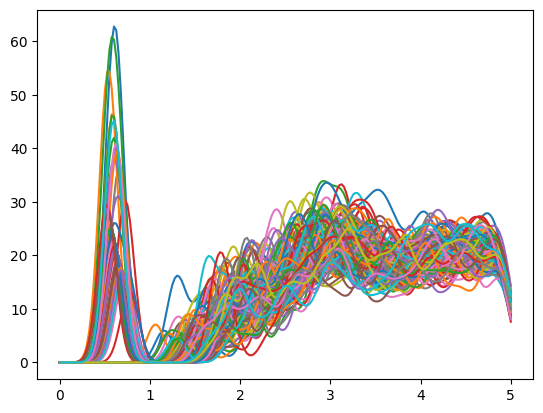

In [114]:
import matplotlib.pyplot as plt

for i, acf in enumerate(acf_t):
    plt.plot(r_grid, acf)

In [57]:
from ase.visualize import view
view(traj_H[51])

<Popen: returncode: None args: ['/Users/ktrerayapiwat/miniconda3/envs/ase-ma...>

In [83]:
from ase.neighborlist import neighbor_list

i, j,d = neighbor_list("ijD",a=traj_H[90], cutoff=3.0)

In [84]:
for i1, i2, dis in zip(i,j,d):
    print(i1, i2, np.linalg.norm(dis))

4 333 1.8533481473938656
4 236 2.7683815993291683
5 186 2.5142857164156607
13 124 2.6498592680622863
18 203 2.6724429317781695
22 23 1.864322336334696
22 232 2.9043518402361443
23 232 2.7018826660814987
23 22 1.864322336334696
36 218 2.850063403624628
38 240 2.998717351885954
40 59 2.9377916207568764
41 235 2.555904136228055
44 76 2.661745506769816
48 358 2.820077412381066
56 229 2.516206584893261
58 225 2.884844698687989
59 40 2.9377916207568764
62 94 2.644794134096051
63 178 2.6145555655138555
71 80 2.7190845702446778
76 44 2.661745506769816
76 86 2.9964608195732962
78 153 2.8371349446894643
80 71 2.7190845702446778
86 231 2.7811367079745346
86 76 2.9964608195732962
94 62 2.644794134096051
95 287 1.585556083150449
95 243 2.5164992910387096
98 123 2.3032685066438963
100 105 2.415924426489494
105 100 2.415924426489494
115 335 2.3881158536066174
115 142 2.4880143843431175
122 293 2.7577762834133526
123 98 2.3032685066438963
124 13 2.6498592680622863
128 274 2.89048646167769
136 188 2.67

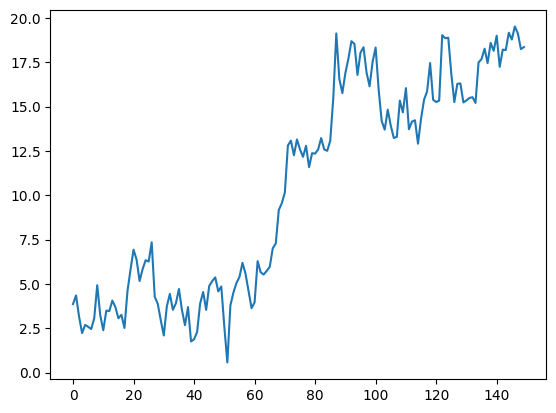

In [71]:
distances_112_132 = np.zeros(len(traj_H))
for i, atoms in enumerate(traj_H):
    distances_112_132[i] = atoms.get_distance(112, 132, mic=True)
    #atoms.get_distance(112,132)
plt.plot(distances_112_132)

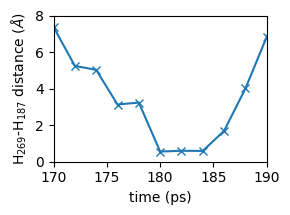

In [113]:
distances_269_187 = np.zeros(len(traj_H))
for i, atoms in enumerate(traj_H):
    distances_269_187[i] = atoms.get_distance(269, 187, mic=True)
    #atoms.get_distance(112,132)
fig, ax = plt.subplots(figsize=[3,2.25])

time = 2*np.arange(distances_269_187.shape[0])
ax.plot(time,distances_269_187, 'x-')
ax.set_xlim([170,190])
ax.set_ylim([0,8])
ax.set_ylabel(r'H$_{269}$-H$_{187}$ distance ($\AA{}$)')
ax.set_xlabel('time (ps)')
fig.tight_layout()
fig.savefig('HH_dis.png', dpi=300)

In [16]:
from ase.neighborlist import neighbor_list

atoms = traj[90]
O_idx = [atom.index for atom in atoms if atom.symbol == 'H']

edge_src, edge_dst, edge_vector = neighbor_list("ijD",
                                                a=atoms,
                                                cutoff=1.5)
for src in O_idx:
    #print(src)
    dst = edge_dst[edge_src==src]
    vec = edge_vector[edge_src==src]
    for d, v in zip(dst, vec):
        if atoms[d].symbol == 'H':
            print(f'Distance from {atoms[src].symbol} {atoms[src].index} to {atoms[d].symbol} {atoms[d].index} is {np.linalg.norm(v): .03f}')

Distance from H 4027 to H 6029 is  0.557
Distance from H 6029 to H 4027 is  0.557
Distance from H 7039 to H 8046 is  1.360
Distance from H 8046 to H 7039 is  1.360


In [25]:
for atoms in traj[90:94]:
    print(atoms.get_forces()[6029])
    print(np.linalg.norm(atoms.get_forces()[4027]))

[ 0.69396085  0.14581102 -0.44503218]
0.47057975077521325
[-1.4660306  -1.00311506 -1.42285407]
1.6365995287095698
[ 0.85679787 -1.73836935  1.14112997]
1.4934192763582084
[0.31551728 0.46095604 0.19638847]
0.3023599093298661


In [112]:
from ase.visualize import view
#atoms = traj[-1]
atoms = traj[90]

edge_src, edge_dst, edge_vector = neighbor_list("ijD",
                                                a=atoms,
                                                cutoff=4)
src = 4027
#src = 114
mask = np.concatenate([edge_dst[edge_src==src],[src]])
traj_truncated = [atoms[mask] for atoms in traj]

for atoms in traj_truncated:
    atoms.translate([20,-20,-10])
    atoms.wrap()

view([atoms[[atom.index for atom in atoms if atom.symbol !='Nd']] for atoms in traj_truncated])

<Popen: returncode: None args: ['/Users/ktrerayapiwat/miniconda3/envs/ase-ma...>

In [142]:
atoms_0 = traj[0]
i=400
#atoms_0.pop(i)
atoms_0_pos = np.vstack([atoms_0.get_positions()[:i], atoms_0.get_positions()[i+1:]])
dis_vec = atoms_t.get_positions()[i] - atoms_0_pos
r_it_j0 = np.linalg.norm(mic(dis_vec, atoms_t.cell),axis=1)
rdf_s = np.sum([gaussian(r,mu =dis, sig=0.15) for dis in r_it_j0], axis=0)

/var/folders/fk/d0qs65yx5sn7pph7l_w3jml80000gs/T/ipykernel_43628/4023159032.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(r,rdf_s/r**2)


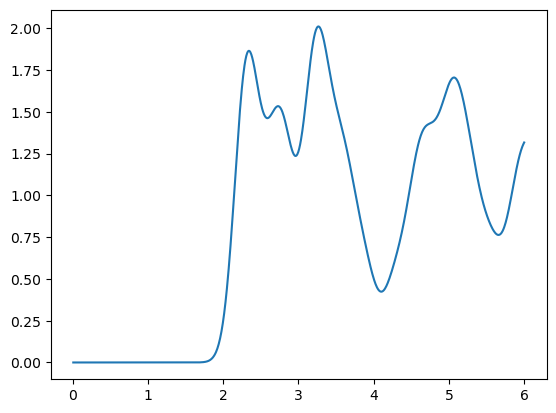

In [143]:
# plt.plot(r, gaussian(r,mu =r_it_j0[0], sig=0.15))
plt.plot(r,rdf_s/r**2)

In [144]:
rdf_s

array([1.44401272e-50, 2.65818021e-50, 4.88541688e-50, 8.96442925e-50,
       1.64228100e-49, 3.00383521e-49, 5.48540312e-49, 1.00010318e-48,
       1.82047567e-48, 3.30848193e-48, 6.00311235e-48, 1.08749681e-47,
       1.96690477e-47, 3.55175088e-47, 6.40332406e-47, 1.15258321e-46,
       2.07129961e-46, 3.71635663e-46, 6.65726236e-46, 1.19063266e-45,
       2.12600236e-45, 3.79012494e-45, 6.74601257e-45, 1.19879411e-44,
       2.12689425e-44, 3.76748066e-44, 6.66284959e-44, 1.17644826e-43,
       2.07390805e-43, 3.65014413e-43, 6.41408009e-43, 1.12528517e-42,
       1.97103650e-42, 3.44691515e-42, 6.01825213e-42, 1.04909308e-41,
       1.82583501e-41, 3.17258235e-41, 5.50386969e-41, 9.53294859e-41,
       1.64850486e-40, 2.84614542e-40, 4.90600307e-40, 8.44310957e-40,
       1.45071104e-39, 2.48864696e-39, 4.26235436e-39, 7.28852595e-39,
       1.24432477e-38, 2.12095613e-38, 3.60938759e-38, 6.13252401e-38,
       1.04027676e-37, 1.76182368e-37, 2.97906444e-37, 5.02922731e-37,
      

In [138]:
rdf_s[0]

1.444012715982703e-50

In [141]:
1/r**2

/var/folders/fk/d0qs65yx5sn7pph7l_w3jml80000gs/T/ipykernel_43628/3958539234.py:1: RuntimeWarning: divide by zero encountered in divide
  1/r**2


array([           inf, 2.77222500e+04, 6.93056250e+03, 3.08025000e+03,
       1.73264062e+03, 1.10889000e+03, 7.70062500e+02, 5.65760204e+02,
       4.33160156e+02, 3.42250000e+02, 2.77222500e+02, 2.29109504e+02,
       1.92515625e+02, 1.64036982e+02, 1.41440051e+02, 1.23210000e+02,
       1.08290039e+02, 9.59247405e+01, 8.55625000e+01, 7.67929363e+01,
       6.93056250e+01, 6.28622449e+01, 5.72773760e+01, 5.24050095e+01,
       4.81289062e+01, 4.43556000e+01, 4.10092456e+01, 3.80277778e+01,
       3.53600128e+01, 3.29634364e+01, 3.08025000e+01, 2.88472945e+01,
       2.70725098e+01, 2.54566116e+01, 2.39811851e+01, 2.26304082e+01,
       2.13906250e+01, 2.02500000e+01, 1.91982341e+01, 1.82263314e+01,
       1.73264062e+01, 1.64915229e+01, 1.57155612e+01, 1.49931044e+01,
       1.43193440e+01, 1.36900000e+01, 1.31012524e+01, 1.25496831e+01,
       1.20322266e+01, 1.15461266e+01, 1.10889000e+01, 1.06583045e+01,
       1.02523114e+01, 9.86908152e+00, 9.50694444e+00, 9.16438017e+00,
      